Below you can see a diagram that represents the workflow of the project. This includes the flow of the original files from start to end, and the actions taken in each step of the process. <br><br>
As you can see we have acquired flat files in JSON format from the official yelp website. Then we have uploaded on of the files on the CosmosDB platform of Microsoft Azure in the MongoDB database that we have created. Due to the size of the files and the resource restrictions, we were not able to upload all of them. The flat files were then parsed into csv format in order to manipulate them as spark dataframes and we moved on to use the reviews dataframe as the basis of our analysis. This was split into 3 sets: <br>
- The <b>development set</b> (500 rows) that was manually labeled and used to perform data understanding, analysis, aggregations feature engineering. This process also involved fetching the file from the MongoDB database to extract information. Then with this set we have created and evaluated the labeling functions. This whole process was iterative, as with each iteration we were imporoving the construction of the labeling functions.<br>
-  The <b>train set</b> containing vast amount of data points was sampled to be able to apply efficiently the previously created labeling functions. This resulted to having a weakly labeled train set that was then augmented using data augmentation techniques like transformation functions. The output of this was the train set that we fit our classifiers in order to come to a final prediction.<br>
- The <b>test set</b> (500 rows) that was manually labeled and used to validate and tune the classifiers.

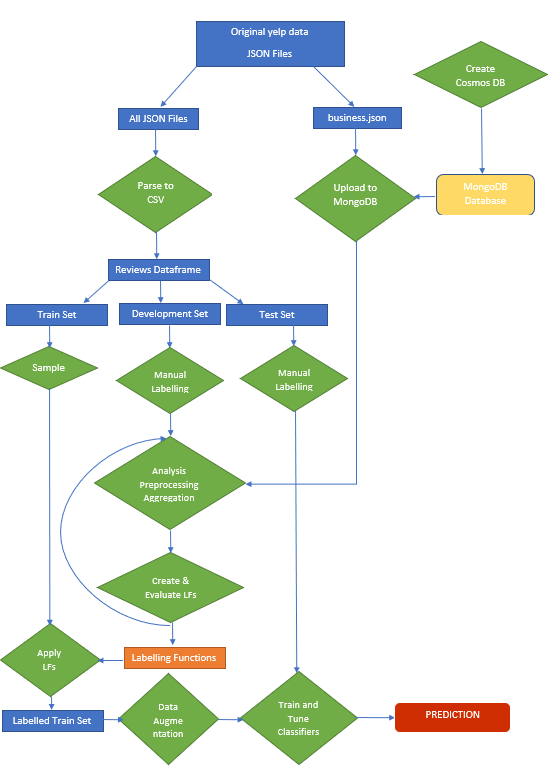

In [46]:
from IPython.display import Image
Image("Diagram.PNG")

In [1]:
#Hey I've added this so we can see properly SQL Views from Spark (Simon)
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Import Spark NLP   
#from sparknlp import DocumentAssembler
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.embeddings import *
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.common import RegexRule

# Start Spark Session with Spark NLP
spark = sparknlp.start()
print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  2.4.1
Apache Spark version:  2.4.4


In [3]:
#Imports
import sys

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import array_contains
from pyspark.ml import Pipeline, PipelineModel

from pyspark.sql import functions as F
from pyspark.sql import SQLContext
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [4]:
df_train = spark.read.csv("review_train.csv", escape='"', multiLine=True,
     inferSchema=True, header=True)

df_train = df_train.withColumnRenamed("label\r", "label")
df_train.show()

+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+------------+
|_c0|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|     index_1|
+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+------------+
|  0|TOeWXJrCBSCdDj7Vn...|   2|2015-01-30 23:56:29|    0|GUx6xAYI5MBSz1IOF...|  3.0|Au Juste Thai was...|     3|41kMyI1BfOTyIIAen...|223338344717|
|  1|5shgJB7a-2_gdnzc0...|   2|2010-11-12 08:53:20|    0|0e8nqF1RAPqB0E-JB...|  4.0|The sangria is ex...|     2|r5ggPC6OccLk6dDl5...|335007509930|
|  2|6ANVuBMmpkXpFd5Hz...|   1|2018-03-13 16:53:47|    1|v3AfOSPOul46V9dB8...|  3.0|It was rediculous...|     0|s8LU5RZbz0B2rKSAX...| 17179951350|
|  3|IP-q2lMq654sboZLw...|   0|2016-04-27 18:21:12|    0|ndmRW84lF8EOMGZLI...|  4.0|BIG!! That's the ...|     0|qHwj63

In [5]:
# Drop unnecessary columns
drop_list = ['business_id', 'date', 'review_id', 'useful', 'user_id', 'index_1']
df_train = df_train.select([column for column in df_train.columns if column not in drop_list])
df_train.show(5)

+---+----+-----+-----+--------------------+
|_c0|cool|funny|stars|                text|
+---+----+-----+-----+--------------------+
|  0|   2|    0|  3.0|Au Juste Thai was...|
|  1|   2|    0|  4.0|The sangria is ex...|
|  2|   1|    1|  3.0|It was rediculous...|
|  3|   0|    0|  4.0|BIG!! That's the ...|
|  4|   1|    1|  4.0|I was a bit intim...|
+---+----+-----+-----+--------------------+
only showing top 5 rows



In [6]:
from sparknlp.pretrained import PretrainedPipeline

# Create a specific pretrained pipeline object
pipeline = PretrainedPipeline("explain_document_dl", lang="en")

# transform the data through the pipeline
transformed_df = pipeline.transform(df_train)
transformed_df.show(5)

explain_document_dl download started this may take some time.
Approx size to download 168.4 MB
[OK!]
+---+----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|cool|funny|stars|                text|            document|            sentence|               token|             checked|               lemma|                stem|                 pos|          embeddings|                 ner|            entities|
+---+----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|   2|    0|  3.0|Au Juste Thai was...|[[document, 0, 80...|[[document, 0, 78...|[[token, 0, 1, Au...|[[token, 0, 1, Au...|[[token, 0

In [7]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.linalg import Vectors, VectorUDT


def avg_vectors(bert_vectors):
  length = len(bert_vectors[0]["embeddings"])
  avg_vec = [0] * length
  for vec in bert_vectors:
    for i, x in enumerate(vec["embeddings"]):
      avg_vec[i] += x
    avg_vec[i] = avg_vec[i] / length
  return avg_vec


#create a udf
avg_vectors_udf = F.udf(avg_vectors, T.ArrayType(T.DoubleType()))
df_doc_vec = transformed_df.withColumn("doc_vector", avg_vectors_udf(F.col("embeddings")))
display(df_doc_vec)

def dense_vector(vec):
    return Vectors.dense(vec)

dense_vector_udf = F.udf(dense_vector, VectorUDT())
training = df_doc_vec.withColumn("features", dense_vector_udf(F.col("doc_vector")))
training.show(5)

DataFrame[_c0: int, cool: int, funny: int, stars: double, text: string, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, token: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, checked: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, lemma: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, stem: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, pos: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, embeddings: array<struct<an

+---+----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|cool|funny|stars|                text|            document|            sentence|               token|             checked|               lemma|                stem|                 pos|          embeddings|                 ner|            entities|          doc_vector|            features|
+---+----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|   2|    0|  3.0|Au Juste Thai was...|[[document, 0, 80...|[[document, 0, 78...|[[token, 0, 1, Au...|[[toke

+---+----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|cool|funny|stars|                text|            document|            sentence|               token|             checked|               lemma|                stem|                 pos|          embeddings|                 ner|            entities|          doc_vector|            features|
+---+----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|   2|    0|  3.0|Au Juste Thai was...|[[document, 0, 80...|[[document, 0, 78...|[[token, 0, 1, Au...|[[toke

### Repeat Process for development set

In [8]:
df_dev = spark.read.csv("review_dev_labelled.csv", escape='"', multiLine=True,
     inferSchema=True, header=True)

df_dev = df_dev.withColumnRenamed("label\r", "label")
df_dev.show(5)

+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+
|  #|         business_id|cool|            date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|
+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+
|  0|XFhnPpO2x0nS-lVkq...|   1|14/02/2017 16:50|    0|o6VZ0cQEfIBvGW15u...|    2|I knew it was a k...|     0|dk5yqirSwDH7Cpp52...|1080000000000|      0|  1.0|
|  1|SRCepG6PbMvwKcfIU...|   0|11/12/2015 02:47|    0|PBy3gB_D1xEiBJDrw...|    2|Average place, bu...|     0|xmtWxX67wF7afssQR...| 730000000000|      1|  1.0|
|  2|pneBBrIzd3SCbbglY...|   2|15/05/2015 19:18|    0|AeyK7AEtbfubw1aD0...|    4|This is a great o...|     4|X4k8ugJaihHVLHq32...| 490000000000|      2|  0.0|
|  3|8enR8Wc0ot9L41JY1...|   0|15/09/2017 13:1

In [9]:
# Remove unnecessary columns
drop_list = ['#','business_id', 'date', 'review_id', 'useful', 'user_id', 'index_1', 'index_2']
df_dev = df_dev.select([column for column in df_dev.columns if column not in drop_list])
df_dev.show(5)

+----+-----+-----+--------------------+-----+
|cool|funny|stars|                text|label|
+----+-----+-----+--------------------+-----+
|   1|    0|    2|I knew it was a k...|  1.0|
|   0|    0|    2|Average place, bu...|  1.0|
|   2|    0|    4|This is a great o...|  0.0|
|   0|    0|    5|We took shelter a...|  0.0|
|   0|    0|    3|Had the burgers o...|  1.0|
+----+-----+-----+--------------------+-----+
only showing top 5 rows



In [10]:
# Transform the data through the pipeline
transformed_df_dev = pipeline.transform(df_dev)
transformed_df_dev.show(5)

+----+-----+-----+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|cool|funny|stars|                text|label|            document|            sentence|               token|             checked|               lemma|                stem|                 pos|          embeddings|                 ner|            entities|
+----+-----+-----+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   1|    0|    2|I knew it was a k...|  1.0|[[document, 0, 78...|[[document, 0, 12...|[[token, 0, 0, I,...|[[token, 0, 0, I,...|[[token, 0, 0, I,...|[[token, 0, 0, i,...|[[pos, 0, 0, PRP,...|[[word_embeddings...|[[named_entity, 0..

In [11]:
#create a udf
avg_vectors_udf = F.udf(avg_vectors, T.ArrayType(T.DoubleType()))
df_doc_vec = transformed_df_dev.withColumn("doc_vector", avg_vectors_udf(F.col("embeddings")))
display(df_doc_vec)

dense_vector_udf = F.udf(dense_vector, VectorUDT())
development = df_doc_vec.withColumn("features", dense_vector_udf(F.col("doc_vector")))
development.show(5)

DataFrame[cool: int, funny: int, stars: int, text: string, label: double, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, token: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, checked: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, lemma: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, stem: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, pos: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, embeddings: array<struct<

+----+-----+-----+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|cool|funny|stars|                text|label|            document|            sentence|               token|             checked|               lemma|                stem|                 pos|          embeddings|                 ner|            entities|          doc_vector|            features|
+----+-----+-----+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   1|    0|    2|I knew it was a k...|  1.0|[[document, 0, 78...|[[document, 0, 12...|[[token, 0, 0, I,..

In [12]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrfit = lr.fit(development)
print("Coefficients: " + str(lrfit.coefficients))
print("Intercept: " + str(lrfit.intercept))

Coefficients: (100,[],[])
Intercept: -0.29001579579800113
